In [1]:
import numpy as np
import sys
import os
import time
import matplotlib.pyplot as plt

from antinature.core.molecular_data import MolecularData
from antinature.core.basis import MixedMatterBasis
from antinature.core.integral_engine import AntinatureIntegralEngine
from antinature.core.hamiltonian import AntinatureHamiltonian
from antinature.core.scf import AntinatureSCF
from antinature.core.correlation import AntinatureCorrelation


Qiskit successfully imported.
Primitives (Estimator) available.


In [2]:

def run_lih_cation():
    """
    Run calculations for lithium hydride cation (LiH+).
    
    This represents the ionized form of lithium hydride, with one electron
    removed, resulting in a positively charged molecular ion.
    """
    print("\n=== Lithium Hydride Cation (LiH+) Analysis ===\n")
    
    # Create LiH+ molecule (in Bohr units)
    # The experimental bond length of LiH is around 1.6 Å = 3.02 Bohr
    # For the cation, we use a slightly shorter bond length
    lih_data = MolecularData(
        atoms=[
            ('Li', np.array([0.0, 0.0, 0.0])),
            ('H', np.array([0.0, 0.0, 2.90]))  # 2.90 Bohr ≈ 1.53 Å
        ],
        n_electrons=3,  # Li: 3e, H: 1e, minus 1e = 3e total
        n_positrons=0,
        charge=1,  # +1 charge (lost one electron)
        name="Lithium Hydride Cation",
        description="Lithium hydride cation (LiH+) with bond length 1.53 Å"
    )
    
    # Print molecular information
    print(f"Molecule: {lih_data.name}")
    print(f"Description: {lih_data.description}")
    print(f"Formula: {lih_data.get_formula()}")
    print(f"Number of electrons: {lih_data.n_electrons}")
    print(f"Charge: {lih_data.charge}")
    print(f"Nuclear repulsion energy: {lih_data.get_nuclear_repulsion_energy():.8f} Hartree")
    
    # Create a basis set
    basis = MixedMatterBasis()
    basis.create_for_molecule(
        atoms=lih_data.atoms,
        e_quality='minimal',  # Use minimal basis for simplicity
        p_quality='none'      # No positron basis needed
    )
    
    # Print basis information
    e_basis_info = basis.electron_basis.get_function_types() if basis.electron_basis else {}
    print("\nBasis set information:")
    print(f"Electron basis functions: {len(basis.electron_basis) if basis.electron_basis else 0}")
    print(f"Electron function types: {e_basis_info}")
    
    # Create integral engine
    engine = AntinatureIntegralEngine()
    
    # Create Hamiltonian
    print("\nBuilding Hamiltonian...")
    t_start = time.time()
    hamiltonian = AntinatureHamiltonian(
        molecular_data=lih_data,
        basis_set=basis,
        integral_engine=engine,
        include_relativistic=False  # No need for relativistic effects for light atoms
    )
    
    # Build the Hamiltonian matrices
    h_matrices = hamiltonian.build_hamiltonian()
    t_hamiltonian = time.time() - t_start
    print(f"Hamiltonian built in {t_hamiltonian:.3f} seconds")
    
    # Create SCF solver
    print("\nStarting SCF calculation...")
    t_start = time.time()
    scf = AntinatureSCF(
        hamiltonian=h_matrices,
        basis_set=basis,
        molecular_data=lih_data,
        max_iterations=50,
        convergence_threshold=1e-6,
        use_diis=True,
        damping_factor=0.5,
        print_level=1
    )
    
    # Run SCF calculation
    scf_results = scf.solve_scf()
    t_scf = time.time() - t_start
    print(f"SCF completed in {t_scf:.3f} seconds")
    
    # Print SCF results
    print(f"\nSCF energy: {scf_results['energy']:.10f} Hartree")
    print(f"Convergence: {scf_results['converged']}")
    print(f"Iterations: {scf_results['iterations']}")
    
    # Try correlation calculations
    print("\nStarting correlation calculations...")
    t_start = time.time()
    try:
        # Create correlation object
        corr = AntinatureCorrelation(
            scf_result=scf_results,
            hamiltonian=h_matrices,
            basis_set=basis,
            molecular_data=lih_data,
            method="MP2"  # Use MP2 for correlation
        )
        
        # Run correlation calculation
        corr_results = corr.compute_correlation()
        t_corr = time.time() - t_start
        print(f"Correlation completed in {t_corr:.3f} seconds")
        
        # Print correlation results
        print(f"\nMP2 correlation energy: {corr_results['correlation_energy']:.10f} Hartree")
        print(f"Total MP2 energy: {corr_results['total_energy']:.10f} Hartree")
        
    except Exception as e:
        print(f"\nError in correlation calculation: {e}")
    
    # Visualize the system
    print("\nVisualizing LiH+ system...")
    lih_data.visualize(show_bonds=True)
    
    return {
        'molecule': lih_data,
        'scf_results': scf_results,
        'correlation_results': corr_results if 'corr_results' in locals() else None
    }
 

In [ ]:

def run_lih_hybrid():
    """
    Run calculations for a hybrid matter-antimatter LiH system.
    
    This represents a theoretical exotic system where we replace one electron
    in the LiH molecule with a positron, creating a hybrid matter-antimatter
    molecular system.
    """
    print("\n=== Hybrid Matter-Antimatter LiH Analysis ===\n")
    
    # Create hybrid LiH molecule
    hybrid_lih_data = MolecularData(
        atoms=[
            ('Li', np.array([0.0, 0.0, 0.0])),
            ('H', np.array([0.0, 0.0, 3.02]))  # 3.02 Bohr ≈ 1.6 Å (standard LiH bond length)
        ],
        n_electrons=3,  # 3 electrons (instead of normal 4)
        n_positrons=1,  # 1 positron (replacing one electron)
        charge=0,       # Overall neutral
        name="Hybrid LiH",
        description="Hybrid matter-antimatter LiH with 3 electrons and 1 positron"
    )
    
    # Print molecular information
    print(f"Molecule: {hybrid_lih_data.name}")
    print(f"Description: {hybrid_lih_data.description}")
    print(f"Formula: {hybrid_lih_data.get_formula()}")
    print(f"Number of electrons: {hybrid_lih_data.n_electrons}")
    print(f"Number of positrons: {hybrid_lih_data.n_positrons}")
    print(f"Nuclear repulsion energy: {hybrid_lih_data.get_nuclear_repulsion_energy():.8f} Hartree")
    
    # Create a basis set for both electrons and positrons
    basis = MixedMatterBasis()
    basis.create_for_molecule(
        atoms=hybrid_lih_data.atoms,
        e_quality='minimal',
        p_quality='minimal'
    )
    
    # Print basis information
    e_basis_info = basis.electron_basis.get_function_types() if basis.electron_basis else {}
    p_basis_info = basis.positron_basis.get_function_types() if basis.positron_basis else {}
    
    print("\nBasis set information:")
    print(f"Electron basis functions: {len(basis.electron_basis) if basis.electron_basis else 0}")
    print(f"Electron function types: {e_basis_info}")
    print(f"Positron basis functions: {len(basis.positron_basis) if basis.positron_basis else 0}")
    print(f"Positron function types: {p_basis_info}")
    
    # Create integral engine with annihilation
    engine = AntinatureIntegralEngine()
    
    # Create Hamiltonian with annihilation
    print("\nBuilding Hamiltonian...")
    t_start = time.time()
    hamiltonian = AntinatureHamiltonian(
        molecular_data=hybrid_lih_data,
        basis_set=basis,
        integral_engine=engine,
        include_annihilation=True,  # Include electron-positron annihilation
        include_relativistic=True
    )
    
    # Build the Hamiltonian matrices
    h_matrices = hamiltonian.build_hamiltonian()
    t_hamiltonian = time.time() - t_start
    print(f"Hamiltonian built in {t_hamiltonian:.3f} seconds")
    
    # Create SCF solver
    print("\nStarting SCF calculation...")
    t_start = time.time()
    scf = AntinatureSCF(
        hamiltonian=h_matrices,
        basis_set=basis,
        molecular_data=hybrid_lih_data,
        max_iterations=75,
        convergence_threshold=1e-5,
        use_diis=True,
        damping_factor=0.7,
        print_level=1
    )
    
    # Run SCF calculation
    scf_results = scf.solve_scf()
    t_scf = time.time() - t_start
    print(f"SCF completed in {t_scf:.3f} seconds")
    
    # Print SCF results
    print(f"\nSCF energy: {scf_results['energy']:.10f} Hartree")
    print(f"Convergence: {scf_results['converged']}")
    print(f"Iterations: {scf_results['iterations']}")
    
    # Visualize the system
    print("\nVisualizing hybrid LiH system...")
    hybrid_lih_data.visualize(show_bonds=True)
    
    return {
        'molecule': hybrid_lih_data,
        'scf_results': scf_results
    }




=== Lithium Hydride Cation (LiH+) Analysis ===

Molecule: Lithium Hydride Cation
Description: Lithium hydride cation (LiH+) with bond length 1.53 Å
Formula: HLi +
Number of electrons: 3
Charge: 1
Nuclear repulsion energy: 1.03448276 Hartree

Basis set information:
Electron basis functions: 2
Electron function types: {'s': 2}

Building Hamiltonian...
Hamiltonian built in 0.002 seconds

Starting SCF calculation...
Iteration 1: Energy = -4.4239509019, ΔE = 4.4239509019, Error = 0.0000000000
Iteration 2: Energy = -4.4239784216, ΔE = 0.0000275197, Error = 0.0000000000
Iteration 3: Energy = -4.4239987595, ΔE = 0.0000203379, Error = 0.0000000000
Iteration 4: Energy = -4.4240124535, ΔE = 0.0000136940, Error = 0.0085417595
Iteration 5: Energy = -4.4240205900, ΔE = 0.0000081365, Error = 0.0062533241
Iteration 6: Energy = -4.4240267423, ΔE = 0.0000061523, Error = 0.0031256912
Iteration 7: Energy = -4.4240303376, ΔE = 0.0000035954, Error = 0.0015621295
Iteration 8: Energy = -4.4240322664, ΔE = 0.

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/antinature/core/basis.py:681: UserWarning: No positron basis parameters for Li with quality none
  warnings.warn(
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/antinature/core/basis.py:681: UserWarning: No positron basis parameters for H with quality none
  warnings.warn(


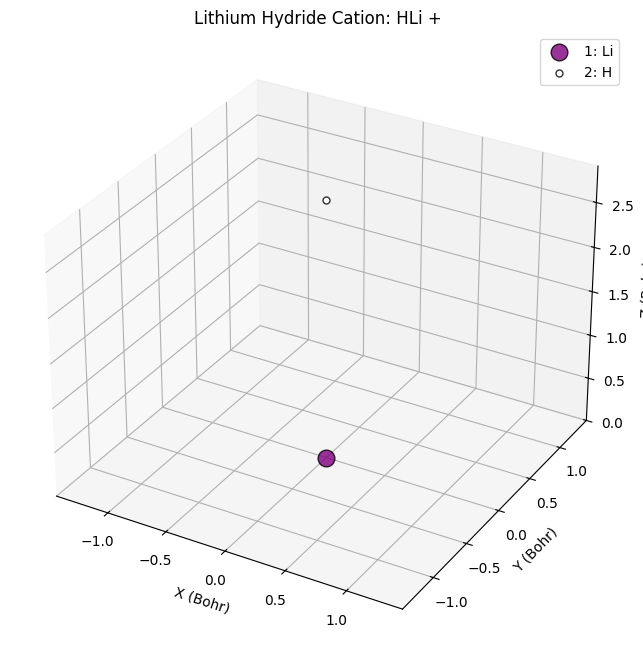


=== Hybrid Matter-Antimatter LiH Analysis ===

Molecule: Hybrid LiH
Description: Hybrid matter-antimatter LiH with 3 electrons and 1 positron
Formula: HLi(e+1)
Number of electrons: 3
Number of positrons: 1
Nuclear repulsion energy: 0.99337748 Hartree

Basis set information:
Electron basis functions: 2
Electron function types: {'s': 2}
Positron basis functions: 2
Positron function types: {'s': 2}

Building Hamiltonian...
Hamiltonian built in 0.002 seconds

Starting SCF calculation...
Iteration 1: Energy = -4.4374999996, ΔE = 4.4374999996, Error = 0.0000000000
Iteration 2: Energy = -4.4375318889, ΔE = 0.0000318893, Error = 0.0000000000
Iteration 3: Energy = -4.4375492313, ΔE = 0.0000173424, Error = 0.0000000000
Iteration 4: Energy = -4.4375574240, ΔE = 0.0000081927, Error = 0.0053514004
Iteration 5: Energy = -4.4375611088, ΔE = 0.0000036848, Error = 0.0033183900
Iteration 6: Energy = -4.4375627966, ΔE = 0.0000016878, Error = 0.0009949299
Iteration 7: Energy = -4.4375633552, ΔE = 0.00000

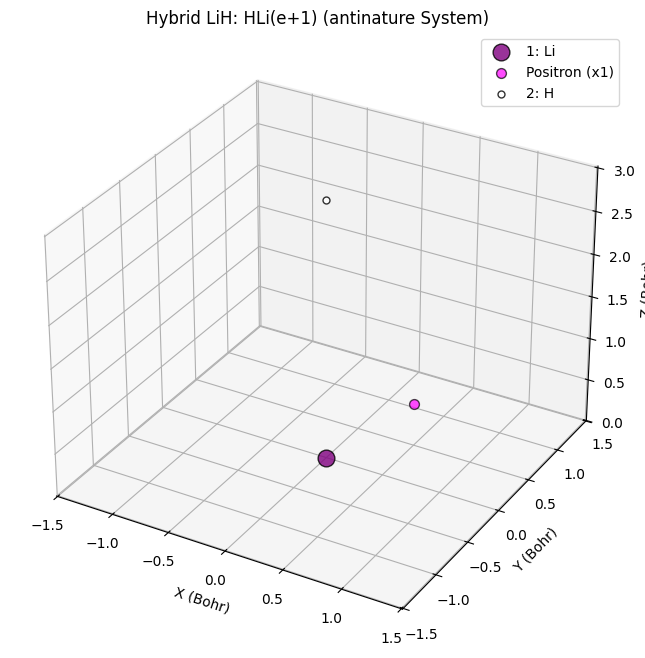

Results saved to results/lih_cation_energies.png and results/hybrid_lih_energies.png


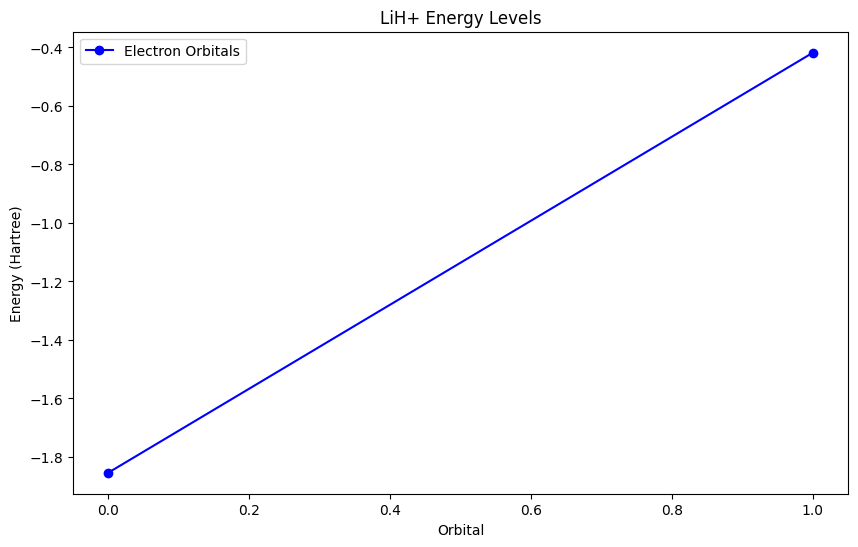

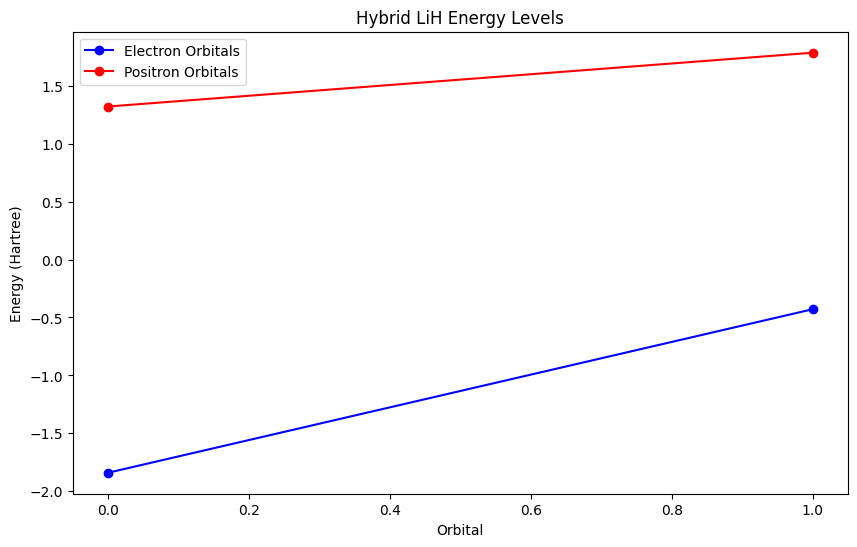

In [4]:
def main():
    """Run all LiH ion examples."""
    # Run the LiH+ example
    lih_results = run_lih_cation()
    
    # Run the hybrid matter-antimatter example
    hybrid_results = run_lih_hybrid()
    
    # Save results plots
    os.makedirs('results', exist_ok=True)
    
    # Plot LiH+ energy levels
    plt.figure(figsize=(10, 6))
    plt.title("LiH+ Energy Levels")
    plt.xlabel("Orbital")
    plt.ylabel("Energy (Hartree)")
    
    # Plot electron energies if available
    if 'E_electron' in lih_results['scf_results']:
        energies = lih_results['scf_results']['E_electron']
        plt.plot(range(len(energies)), energies, 'bo-', label='Electron Orbitals')
        plt.legend()
    
    plt.savefig(os.path.join('results', 'lih_cation_energies.png'))
    
    # Plot hybrid energy levels
    plt.figure(figsize=(10, 6))
    plt.title("Hybrid LiH Energy Levels")
    plt.xlabel("Orbital")
    plt.ylabel("Energy (Hartree)")
    
    # Plot electron and positron energies if available
    if 'E_electron' in hybrid_results['scf_results']:
        e_energies = hybrid_results['scf_results']['E_electron']
        plt.plot(range(len(e_energies)), e_energies, 'bo-', label='Electron Orbitals')
    
    if 'E_positron' in hybrid_results['scf_results']:
        p_energies = hybrid_results['scf_results']['E_positron']
        plt.plot(range(len(p_energies)), p_energies, 'ro-', label='Positron Orbitals')
    
    plt.legend()
    plt.savefig(os.path.join('results', 'hybrid_lih_energies.png'))
    
    print(f"Results saved to results/lih_cation_energies.png and results/hybrid_lih_energies.png")

if __name__ == "__main__":
    main()